- Hatmap
- Melhorar o plot de imagens
- Propor algo novo

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import cv2
from torch.autograd import Variable
import random
import shutil, sys
import pandas as pd
from PIL import Image
from PIL import ImageFile
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "densenet"

# Number of classes in the dataset
#num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#num_epochs = 500

In [3]:
test = 2

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# trans = ['train','val','test']
# categories = ['train','val','test']

class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device.reset()

Initializing Datasets and Dataloaders...


In [5]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'normal/')]) + len([iq for iq in os.scandir(train_dir+'pneumonia/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'normal/')]) + len([iq for iq in os.scandir(test_dir+'pneumonia/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'normal/')]) + len([iq for iq in os.scandir(val_dir+'pneumonia/')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)

print("pneumonia : ", len_normal)

print("covid : ", len_pneumonia)

print("-"*20)

print('Train, test, validation')

print("-"*20)

print("len_train_dir : ", len_train_dir)

print("len_test_dir : ", len_test_dir)

print("len_val_dir : ", len_val_dir)



Files per classes
----------------------------------------
normal :  4023
pneumonia :  4035
covid :  4105
--------------------
Train, test, validation
--------------------
len_train_dir :  9632
len_test_dir :  31
len_val_dir :  2409


In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, 
                model_name, lr, batch_size, opt_name, crt_name):
    since = time.time()
    is_inception = False
    
    #tensorboard
    writer = SummaryWriter(f'runs/dg_{model_name}_lr={lr}_epoch={num_epochs}_batch_size={batch_size}')
    step = 0

    val_acc_history = []
    val_loss_history = []
    
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            writer.add_scalar('training loss', loss, global_step=step)
            writer.add_scalar('training accuracy', epoch_acc, global_step=step)
            step += 1
            
            #only to plot the graph
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()
        
        
    time_elapsed = time.time() - since
    print()
    print('#'*30)
    print('------ Summary ------')
    print(f'model -> {_model}')
    print(f'epochs -> {_epochs}')
    print(f'lr -> {_lrs}')
    print(f'batch size -> {_batch}')
    print(f'optimizer -> {opt_name}'), 
    print(f'criteriun -> {crt_name}')
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('#'*30)
    
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.plot(train_acc_history, label="Validation Loss")
    plt.title('Accuracy and Loss in Validation Dataset')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_loss_history, label="val_loss_history")
    plt.plot(train_loss_history, label="train_loss_history")
    plt.legend()
    plt.tight_layout()
    plt.savefig('hist_'+_model+'_opt_'+opt_name+'_crt_'+crt_name+'.png')
    plt.show()

    print()

    print('==== END ====')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [7]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [10]:
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm_'+title+'.png')


==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.4019 Acc: 0.8487
val Loss: 0.2357 Acc: 0.9191

Epoch 1/299
----------
train Loss: 0.3120 Acc: 0.8820
val Loss: 0.2587 Acc: 0.9070

Epoch 2/299
----------
train Loss: 0.2948 Acc: 0.8851
val Loss: 0.2051 Acc: 0.9278

Epoch 3/299
----------
train Loss: 0.2867 Acc: 0.8877
val Loss: 0.1986 Acc: 0.9294

Epoch 4/299
----------
train Loss: 0.2797 Acc: 0.8970
val Loss: 0.2385 Acc: 0.9112

Epoch 5/299
----------
train Loss: 0.2759 Acc: 0.8953
val Loss: 0.2119 Acc: 0.9186

Epoch 6/299
----------
train Loss: 0.2650 Acc: 0.9000
val Loss: 0.2016 Acc: 0.9261

Epoch 7/299
----------
train Loss: 0.2668 Acc: 0.8991
val Loss: 0.1686 Acc: 0.9406

Epoch 8/299
----------
train Loss: 0.2747 Acc: 0.8957
val Loss: 0.2104 Acc: 0.92

train Loss: 0.2243 Acc: 0.9167
val Loss: 0.1432 Acc: 0.9498

Epoch 94/299
----------
train Loss: 0.2242 Acc: 0.9131
val Loss: 0.1465 Acc: 0.9506

Epoch 95/299
----------
train Loss: 0.2277 Acc: 0.9142
val Loss: 0.1629 Acc: 0.9348

Epoch 96/299
----------
train Loss: 0.2304 Acc: 0.9099
val Loss: 0.1407 Acc: 0.9498

Epoch 97/299
----------
train Loss: 0.2320 Acc: 0.9128
val Loss: 0.1436 Acc: 0.9489

Epoch 98/299
----------
train Loss: 0.2318 Acc: 0.9112
val Loss: 0.1549 Acc: 0.9431

Epoch 99/299
----------
train Loss: 0.2234 Acc: 0.9155
val Loss: 0.1605 Acc: 0.9398

Epoch 100/299
----------
train Loss: 0.2250 Acc: 0.9143
val Loss: 0.1913 Acc: 0.9278

Epoch 101/299
----------
train Loss: 0.2154 Acc: 0.9170
val Loss: 0.1822 Acc: 0.9311

Epoch 102/299
----------
train Loss: 0.2228 Acc: 0.9175
val Loss: 0.1594 Acc: 0.9435

Epoch 103/299
----------
train Loss: 0.2214 Acc: 0.9142
val Loss: 0.1997 Acc: 0.9274

Epoch 104/299
----------
train Loss: 0.2224 Acc: 0.9155
val Loss: 0.1631 Acc: 0.9394


val Loss: 0.1275 Acc: 0.9560

Epoch 189/299
----------
train Loss: 0.2230 Acc: 0.9141
val Loss: 0.1472 Acc: 0.9465

Epoch 190/299
----------
train Loss: 0.2174 Acc: 0.9166
val Loss: 0.1426 Acc: 0.9469

Epoch 191/299
----------
train Loss: 0.2224 Acc: 0.9146
val Loss: 0.1522 Acc: 0.9431

Epoch 192/299
----------
train Loss: 0.2203 Acc: 0.9143
val Loss: 0.1509 Acc: 0.9423

Epoch 193/299
----------
train Loss: 0.2222 Acc: 0.9140
val Loss: 0.1697 Acc: 0.9348

Epoch 194/299
----------
train Loss: 0.2185 Acc: 0.9176
val Loss: 0.2171 Acc: 0.9182

Epoch 195/299
----------
train Loss: 0.2130 Acc: 0.9199
val Loss: 0.1324 Acc: 0.9523

Epoch 196/299
----------
train Loss: 0.2144 Acc: 0.9183
val Loss: 0.1782 Acc: 0.9332

Epoch 197/299
----------
train Loss: 0.2176 Acc: 0.9164
val Loss: 0.1524 Acc: 0.9435

Epoch 198/299
----------
train Loss: 0.2182 Acc: 0.9191
val Loss: 0.1552 Acc: 0.9406

Epoch 199/299
----------
train Loss: 0.2162 Acc: 0.9156
val Loss: 0.1535 Acc: 0.9406

Epoch 200/299
----------

train Loss: 0.2194 Acc: 0.9161
val Loss: 0.1262 Acc: 0.9577

Epoch 285/299
----------
train Loss: 0.2198 Acc: 0.9161
val Loss: 0.1600 Acc: 0.9377

Epoch 286/299
----------
train Loss: 0.2176 Acc: 0.9176
val Loss: 0.1798 Acc: 0.9315

Epoch 287/299
----------
train Loss: 0.2187 Acc: 0.9173
val Loss: 0.1567 Acc: 0.9415

Epoch 288/299
----------
train Loss: 0.2181 Acc: 0.9161
val Loss: 0.1710 Acc: 0.9348

Epoch 289/299
----------
train Loss: 0.2207 Acc: 0.9143
val Loss: 0.1385 Acc: 0.9465

Epoch 290/299
----------
train Loss: 0.2135 Acc: 0.9190
val Loss: 0.1348 Acc: 0.9485

Epoch 291/299
----------
train Loss: 0.2282 Acc: 0.9141
val Loss: 0.2400 Acc: 0.9070

Epoch 292/299
----------
train Loss: 0.2210 Acc: 0.9122
val Loss: 0.2001 Acc: 0.9232

Epoch 293/299
----------
train Loss: 0.2180 Acc: 0.9150
val Loss: 0.1474 Acc: 0.9460

Epoch 294/299
----------
train Loss: 0.2125 Acc: 0.9177
val Loss: 0.1654 Acc: 0.9357

Epoch 295/299
----------
train Loss: 0.2167 Acc: 0.9212
val Loss: 0.1711 Acc: 0

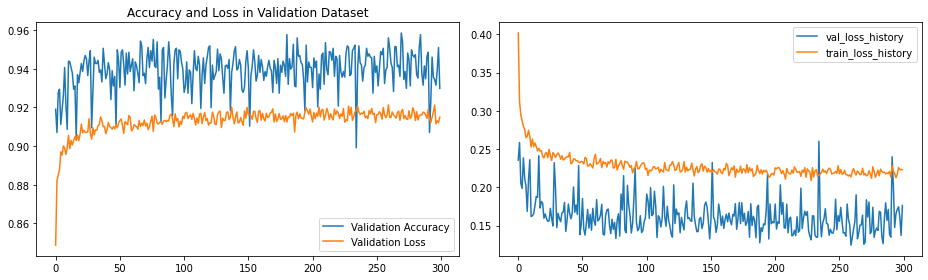


==== END ====
[[775   3  13]
 [  5 774  20]
 [  4  55 760]]

Sensitivity or recall total
0.95848899958489

Sensitivity or recall per classes
[0.97977244 0.96871089 0.92796093]

Precision
[0.98852041 0.93028846 0.95838588]

F1 Score
[0.98412698 0.94911097 0.94292804]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 2

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -406.1788 Acc: 0.4983
val Loss: -835.0759 Acc: 0.4907

Epoch 1/299
----------
train Loss: -1231.8632 Acc: 0.4962
val Loss: -1676.8388 Acc: 0.4907

Epoch 2/299
----------
train Loss: -2057.4315 Acc: 0.4871
val Loss: -2518.4024 Acc: 0.4902

Epoch 3/299
----------
train Loss: -2883.6774 Acc: 0.4951
val Loss: -3360.4065 Acc: 0.4898

Epoch 4/299
----------
train Loss: -3710.0119 Acc: 0.4919
val Loss: -4202.0162

train Loss: -66498.4445 Acc: 0.4885
val Loss: -68159.4467 Acc: 0.4873

Epoch 81/299
----------
train Loss: -67284.5813 Acc: 0.4864
val Loss: -69001.2642 Acc: 0.4873

Epoch 82/299
----------
train Loss: -68159.7279 Acc: 0.4861
val Loss: -69843.4919 Acc: 0.4873

Epoch 83/299
----------
train Loss: -69056.5809 Acc: 0.4861
val Loss: -70686.5477 Acc: 0.4873

Epoch 84/299
----------
train Loss: -69800.3601 Acc: 0.4892
val Loss: -71528.7542 Acc: 0.4873

Epoch 85/299
----------
train Loss: -70596.0964 Acc: 0.4870
val Loss: -72370.3860 Acc: 0.4873

Epoch 86/299
----------
train Loss: -71360.1580 Acc: 0.4871
val Loss: -73211.3059 Acc: 0.4873

Epoch 87/299
----------
train Loss: -72203.9376 Acc: 0.4873
val Loss: -74052.7161 Acc: 0.4873

Epoch 88/299
----------
train Loss: -73065.7184 Acc: 0.4894
val Loss: -74894.1667 Acc: 0.4873

Epoch 89/299
----------
train Loss: -73908.4203 Acc: 0.4880
val Loss: -75735.9967 Acc: 0.4873

Epoch 90/299
----------
train Loss: -74773.1578 Acc: 0.4883
val Loss: -765

train Loss: -136646.3955 Acc: 0.4846
val Loss: -139706.6241 Acc: 0.4873

Epoch 166/299
----------
train Loss: -137653.8426 Acc: 0.4847
val Loss: -140549.2279 Acc: 0.4873

Epoch 167/299
----------
train Loss: -138359.7222 Acc: 0.4876
val Loss: -141391.2790 Acc: 0.4873

Epoch 168/299
----------
train Loss: -138879.6016 Acc: 0.4863
val Loss: -142231.3960 Acc: 0.4873

Epoch 169/299
----------
train Loss: -140022.7680 Acc: 0.4876
val Loss: -143073.4059 Acc: 0.4873

Epoch 170/299
----------
train Loss: -140666.1378 Acc: 0.4863
val Loss: -143914.5039 Acc: 0.4873

Epoch 171/299
----------
train Loss: -141443.7374 Acc: 0.4865
val Loss: -144755.0893 Acc: 0.4873

Epoch 172/299
----------
train Loss: -142117.3352 Acc: 0.4884
val Loss: -145594.7542 Acc: 0.4873

Epoch 173/299
----------
train Loss: -143422.1495 Acc: 0.4846
val Loss: -146437.4005 Acc: 0.4873

Epoch 174/299
----------
train Loss: -144027.7954 Acc: 0.4893
val Loss: -147278.6201 Acc: 0.4873

Epoch 175/299
----------
train Loss: -145025.

train Loss: -205700.0241 Acc: 0.4891
val Loss: -210396.5096 Acc: 0.4873

Epoch 250/299
----------
train Loss: -206916.3597 Acc: 0.4867
val Loss: -211238.5395 Acc: 0.4873

Epoch 251/299
----------
train Loss: -207360.5052 Acc: 0.4871
val Loss: -212078.7652 Acc: 0.4873

Epoch 252/299
----------
train Loss: -208257.4925 Acc: 0.4886
val Loss: -212919.6141 Acc: 0.4873

Epoch 253/299
----------
train Loss: -209577.9236 Acc: 0.4888
val Loss: -213762.1779 Acc: 0.4873

Epoch 254/299
----------
train Loss: -210481.4610 Acc: 0.4885
val Loss: -214605.2960 Acc: 0.4873

Epoch 255/299
----------
train Loss: -210929.2493 Acc: 0.4906
val Loss: -215446.7441 Acc: 0.4873

Epoch 256/299
----------
train Loss: -211903.8411 Acc: 0.4893
val Loss: -216288.7529 Acc: 0.4873

Epoch 257/299
----------
train Loss: -212249.1583 Acc: 0.4866
val Loss: -217129.0676 Acc: 0.4873

Epoch 258/299
----------
train Loss: -213239.4522 Acc: 0.4891
val Loss: -217970.0549 Acc: 0.4873

Epoch 259/299
----------
train Loss: -213943.

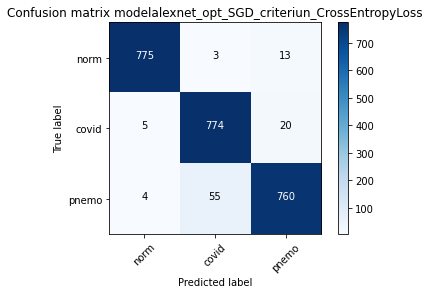

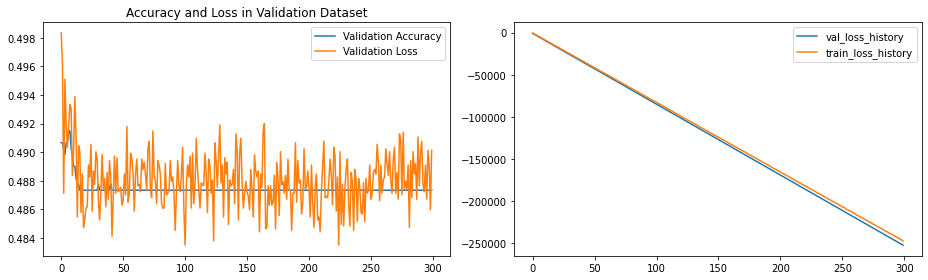


==== END ====
[[308 413  70]
 [  0 799   0]
 [  4 738  77]]

Sensitivity or recall total
0.49149024491490245

Sensitivity or recall per classes
[0.39 1.   0.09]

Precision
[0.99 0.41 0.52]

F1 Score
[0.56 0.58 0.16]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.4478 Acc: 0.8349
val Loss: 0.2999 Acc: 0.9016

Epoch 1/299
----------
train Loss: 0.3124 Acc: 0.8833
val Loss: 0.2532 Acc: 0.9049

Epoch 2/299
----------
train Loss: 0.2946 Acc: 0.8902
val Loss: 0.2214 Acc: 0.9228

Epoch 3/299
----------
train Loss: 0.2797 Acc: 0.8969
val Loss: 0.2065 Acc: 0.9328

Epoch 4/299
----------
train Loss: 0.2642 Acc: 0.9020
val Loss: 0.2045 Acc: 0.9269

Epoch 5/299
----------
train Loss: 0.2656 Acc: 0.8999
val Loss: 0.1999 Acc:

train Loss: 0.2120 Acc: 0.9200
val Loss: 0.1438 Acc: 0.9481

Epoch 91/299
----------
train Loss: 0.2105 Acc: 0.9192
val Loss: 0.1567 Acc: 0.9435

Epoch 92/299
----------
train Loss: 0.2146 Acc: 0.9188
val Loss: 0.1604 Acc: 0.9406

Epoch 93/299
----------
train Loss: 0.2111 Acc: 0.9192
val Loss: 0.1600 Acc: 0.9386

Epoch 94/299
----------
train Loss: 0.2097 Acc: 0.9214
val Loss: 0.1802 Acc: 0.9303

Epoch 95/299
----------
train Loss: 0.2117 Acc: 0.9216
val Loss: 0.1693 Acc: 0.9344

Epoch 96/299
----------
train Loss: 0.2080 Acc: 0.9201
val Loss: 0.1585 Acc: 0.9402

Epoch 97/299
----------
train Loss: 0.2075 Acc: 0.9195
val Loss: 0.1679 Acc: 0.9340

Epoch 98/299
----------
train Loss: 0.2159 Acc: 0.9194
val Loss: 0.1609 Acc: 0.9390

Epoch 99/299
----------
train Loss: 0.2029 Acc: 0.9238
val Loss: 0.1405 Acc: 0.9473

Epoch 100/299
----------
train Loss: 0.2090 Acc: 0.9191
val Loss: 0.1343 Acc: 0.9527

Epoch 101/299
----------
train Loss: 0.2170 Acc: 0.9189
val Loss: 0.1473 Acc: 0.9456

Ep

train Loss: 0.2024 Acc: 0.9237
val Loss: 0.1316 Acc: 0.9535

Epoch 187/299
----------
train Loss: 0.2032 Acc: 0.9228
val Loss: 0.1236 Acc: 0.9577

Epoch 188/299
----------
train Loss: 0.2053 Acc: 0.9210
val Loss: 0.1315 Acc: 0.9523

Epoch 189/299
----------
train Loss: 0.2000 Acc: 0.9227
val Loss: 0.1690 Acc: 0.9328

Epoch 190/299
----------
train Loss: 0.2058 Acc: 0.9193
val Loss: 0.1331 Acc: 0.9518

Epoch 191/299
----------
train Loss: 0.2087 Acc: 0.9217
val Loss: 0.1541 Acc: 0.9415

Epoch 192/299
----------
train Loss: 0.2075 Acc: 0.9199
val Loss: 0.1812 Acc: 0.9307

Epoch 193/299
----------
train Loss: 0.2027 Acc: 0.9219
val Loss: 0.1389 Acc: 0.9489

Epoch 194/299
----------
train Loss: 0.2068 Acc: 0.9199
val Loss: 0.1320 Acc: 0.9523

Epoch 195/299
----------
train Loss: 0.2008 Acc: 0.9234
val Loss: 0.1504 Acc: 0.9427

Epoch 196/299
----------
train Loss: 0.2028 Acc: 0.9236
val Loss: 0.1519 Acc: 0.9411

Epoch 197/299
----------
train Loss: 0.2011 Acc: 0.9235
val Loss: 0.1507 Acc: 0

val Loss: 0.1384 Acc: 0.9489

Epoch 282/299
----------
train Loss: 0.2035 Acc: 0.9229
val Loss: 0.1304 Acc: 0.9543

Epoch 283/299
----------
train Loss: 0.2147 Acc: 0.9207
val Loss: 0.1453 Acc: 0.9440

Epoch 284/299
----------
train Loss: 0.2070 Acc: 0.9202
val Loss: 0.1372 Acc: 0.9489

Epoch 285/299
----------
train Loss: 0.2107 Acc: 0.9191
val Loss: 0.1313 Acc: 0.9527

Epoch 286/299
----------
train Loss: 0.2036 Acc: 0.9218
val Loss: 0.1437 Acc: 0.9473

Epoch 287/299
----------
train Loss: 0.1968 Acc: 0.9238
val Loss: 0.1495 Acc: 0.9448

Epoch 288/299
----------
train Loss: 0.2003 Acc: 0.9202
val Loss: 0.1272 Acc: 0.9552

Epoch 289/299
----------
train Loss: 0.2070 Acc: 0.9228
val Loss: 0.1248 Acc: 0.9577

Epoch 290/299
----------
train Loss: 0.1999 Acc: 0.9241
val Loss: 0.1461 Acc: 0.9435

Epoch 291/299
----------
train Loss: 0.2037 Acc: 0.9206
val Loss: 0.1421 Acc: 0.9448

Epoch 292/299
----------
train Loss: 0.2110 Acc: 0.9190
val Loss: 0.1288 Acc: 0.9548

Epoch 293/299
----------

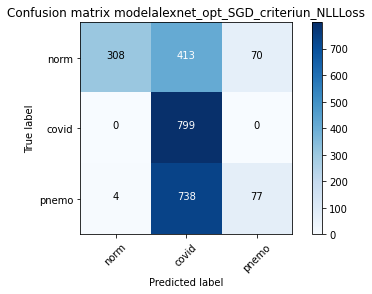

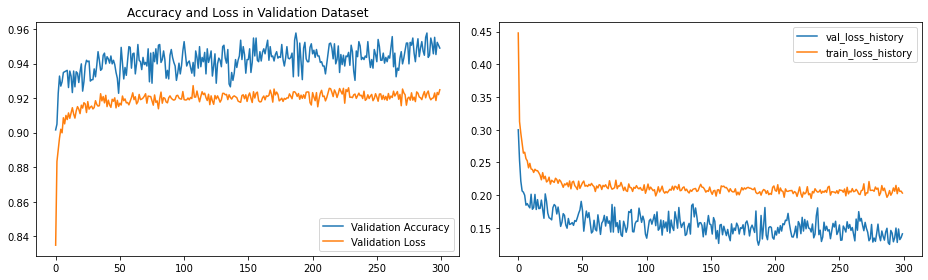


==== END ====
[[778   2  11]
 [  4 771  24]
 [  5  56 758]]

Sensitivity or recall total
0.9576587795765878

Sensitivity or recall per classes
[0.98 0.96 0.93]

Precision
[0.99 0.93 0.96]

F1 Score
[0.99 0.95 0.94]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 2

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -43.6402 Acc: 0.5987
val Loss: -83.5471 Acc: 0.7360

Epoch 1/299
----------
train Loss: -131.4487 Acc: 0.7760
val Loss: -167.3366 Acc: 0.8248

Epoch 2/299
----------
train Loss: -218.8816 Acc: 0.8075
val Loss: -251.0649 Acc: 0.8149

Epoch 3/299
----------
train Loss: -305.8522 Acc: 0.8032
val Loss: -334.8822 Acc: 0.8120

Epoch 4/299
----------
train Loss: -393.8761 Acc: 0.7979
val Loss: -418.6766 Acc: 0.8082

Epoch 5/299
----------
train Loss: -482.2114 Acc

val Loss: -6954.6663 Acc: 0.7866

Epoch 83/299
----------
train Loss: -7320.9595 Acc: 0.7861
val Loss: -7038.5704 Acc: 0.7866

Epoch 84/299
----------
train Loss: -7416.5607 Acc: 0.7902
val Loss: -7122.5560 Acc: 0.7854

Epoch 85/299
----------
train Loss: -7497.0901 Acc: 0.7844
val Loss: -7206.1341 Acc: 0.7875

Epoch 86/299
----------
train Loss: -7585.6884 Acc: 0.7906
val Loss: -7289.6566 Acc: 0.7875

Epoch 87/299
----------
train Loss: -7668.7057 Acc: 0.7891
val Loss: -7373.3532 Acc: 0.7866

Epoch 88/299
----------
train Loss: -7759.0636 Acc: 0.7854
val Loss: -7457.2858 Acc: 0.7866

Epoch 89/299
----------
train Loss: -7846.9071 Acc: 0.7865
val Loss: -7540.9446 Acc: 0.7854

Epoch 90/299
----------
train Loss: -7938.3706 Acc: 0.7831
val Loss: -7624.7627 Acc: 0.7846

Epoch 91/299
----------
train Loss: -8022.3032 Acc: 0.7861
val Loss: -7708.5688 Acc: 0.7850

Epoch 92/299
----------
train Loss: -8119.4183 Acc: 0.7856
val Loss: -7792.6588 Acc: 0.7846

Epoch 93/299
----------
train Loss: 

train Loss: -14887.8030 Acc: 0.7871
val Loss: -14246.0664 Acc: 0.7887

Epoch 170/299
----------
train Loss: -14976.7363 Acc: 0.7891
val Loss: -14330.0034 Acc: 0.7879

Epoch 171/299
----------
train Loss: -15052.1104 Acc: 0.7855
val Loss: -14413.7920 Acc: 0.7879

Epoch 172/299
----------
train Loss: -15125.4726 Acc: 0.7917
val Loss: -14497.7257 Acc: 0.7879

Epoch 173/299
----------
train Loss: -15224.7786 Acc: 0.7880
val Loss: -14581.4920 Acc: 0.7879

Epoch 174/299
----------
train Loss: -15301.5048 Acc: 0.7858
val Loss: -14665.1885 Acc: 0.7875

Epoch 175/299
----------
train Loss: -15410.8433 Acc: 0.7877
val Loss: -14749.0883 Acc: 0.7875

Epoch 176/299
----------
train Loss: -15483.3509 Acc: 0.7855
val Loss: -14832.7827 Acc: 0.7875

Epoch 177/299
----------
train Loss: -15556.9707 Acc: 0.7860
val Loss: -14916.6529 Acc: 0.7879

Epoch 178/299
----------
train Loss: -15660.7404 Acc: 0.7884
val Loss: -15000.7406 Acc: 0.7879

Epoch 179/299
----------
train Loss: -15744.5107 Acc: 0.7943
val 

val Loss: -21368.8025 Acc: 0.7912

Epoch 255/299
----------
train Loss: -22413.2151 Acc: 0.7887
val Loss: -21452.5810 Acc: 0.7912

Epoch 256/299
----------
train Loss: -22482.2236 Acc: 0.7883
val Loss: -21536.4739 Acc: 0.7912

Epoch 257/299
----------
train Loss: -22592.9394 Acc: 0.7863
val Loss: -21620.3256 Acc: 0.7908

Epoch 258/299
----------
train Loss: -22686.3056 Acc: 0.7930
val Loss: -21704.1120 Acc: 0.7904

Epoch 259/299
----------
train Loss: -22739.3606 Acc: 0.7884
val Loss: -21787.9190 Acc: 0.7904

Epoch 260/299
----------
train Loss: -22804.0093 Acc: 0.7901
val Loss: -21871.8415 Acc: 0.7908

Epoch 261/299
----------
train Loss: -22942.0519 Acc: 0.7884
val Loss: -21955.7028 Acc: 0.7916

Epoch 262/299
----------
train Loss: -23006.0620 Acc: 0.7885
val Loss: -22039.5090 Acc: 0.7920

Epoch 263/299
----------
train Loss: -23119.4511 Acc: 0.7873
val Loss: -22123.3282 Acc: 0.7916

Epoch 264/299
----------
train Loss: -23182.0821 Acc: 0.7880
val Loss: -22206.9375 Acc: 0.7904

Epoch

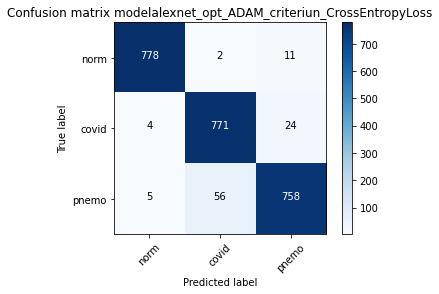

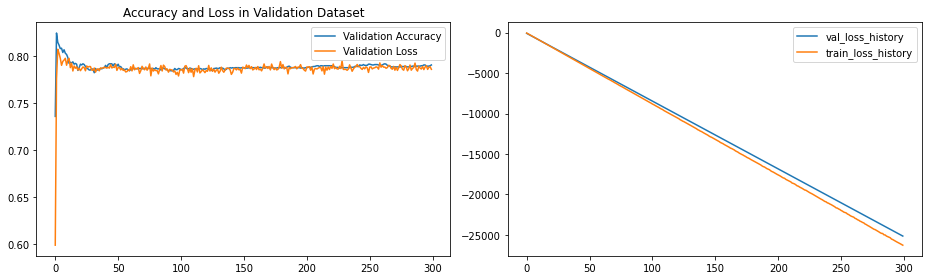


==== END ====
[[603 106  82]
 [  2 747  50]
 [ 58 124 637]]

Sensitivity or recall total
0.8248235782482358

Sensitivity or recall per classes
[0.76 0.93 0.78]

Precision
[0.91 0.76 0.83]

F1 Score
[0.83 0.84 0.8 ]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.4055 Acc: 0.8507
val Loss: 0.2791 Acc: 0.9091

Epoch 1/299
----------
train Loss: 0.3102 Acc: 0.8843
val Loss: 0.2579 Acc: 0.9049

Epoch 2/299
----------
train Loss: 0.2890 Acc: 0.8907
val Loss: 0.2383 Acc: 0.9149

Epoch 3/299
----------
train Loss: 0.2753 Acc: 0.8961
val Loss: 0.2397 Acc: 0.9112

Epoch 4/299
----------
train Loss: 0.2638 Acc: 0.9018
val Loss: 0.2102 Acc: 0.9244

Epoch 5/299
----------
train Loss: 0.2578 Acc: 0.9052
val Loss: 0.1972 Acc: 

train Loss: 0.2164 Acc: 0.9181
val Loss: 0.1510 Acc: 0.9435

Epoch 91/299
----------
train Loss: 0.2117 Acc: 0.9213
val Loss: 0.1638 Acc: 0.9427

Epoch 92/299
----------
train Loss: 0.2112 Acc: 0.9224
val Loss: 0.1514 Acc: 0.9435

Epoch 93/299
----------
train Loss: 0.2137 Acc: 0.9199
val Loss: 0.1566 Acc: 0.9423

Epoch 94/299
----------
train Loss: 0.2169 Acc: 0.9205
val Loss: 0.1429 Acc: 0.9518

Epoch 95/299
----------
train Loss: 0.2192 Acc: 0.9188
val Loss: 0.1621 Acc: 0.9411

Epoch 96/299
----------
train Loss: 0.2143 Acc: 0.9200
val Loss: 0.1536 Acc: 0.9431

Epoch 97/299
----------
train Loss: 0.2179 Acc: 0.9175
val Loss: 0.1363 Acc: 0.9539

Epoch 98/299
----------
train Loss: 0.2204 Acc: 0.9176
val Loss: 0.1485 Acc: 0.9469

Epoch 99/299
----------
train Loss: 0.2163 Acc: 0.9184
val Loss: 0.1446 Acc: 0.9498

Epoch 100/299
----------
train Loss: 0.2118 Acc: 0.9225
val Loss: 0.1427 Acc: 0.9506

Epoch 101/299
----------
train Loss: 0.2149 Acc: 0.9195
val Loss: 0.1546 Acc: 0.9411

Ep

train Loss: 0.2158 Acc: 0.9186
val Loss: 0.1546 Acc: 0.9419

Epoch 187/299
----------
train Loss: 0.2230 Acc: 0.9177
val Loss: 0.1364 Acc: 0.9514

Epoch 188/299
----------
train Loss: 0.2190 Acc: 0.9161
val Loss: 0.1470 Acc: 0.9485

Epoch 189/299
----------
train Loss: 0.2165 Acc: 0.9187
val Loss: 0.1596 Acc: 0.9394

Epoch 190/299
----------
train Loss: 0.2143 Acc: 0.9219
val Loss: 0.1551 Acc: 0.9431

Epoch 191/299
----------
train Loss: 0.2086 Acc: 0.9205
val Loss: 0.1672 Acc: 0.9373

Epoch 192/299
----------
train Loss: 0.2125 Acc: 0.9245
val Loss: 0.1541 Acc: 0.9444

Epoch 193/299
----------
train Loss: 0.2150 Acc: 0.9172
val Loss: 0.1428 Acc: 0.9489

Epoch 194/299
----------
train Loss: 0.2233 Acc: 0.9168
val Loss: 0.1570 Acc: 0.9440

Epoch 195/299
----------
train Loss: 0.2178 Acc: 0.9181
val Loss: 0.1796 Acc: 0.9294

Epoch 196/299
----------
train Loss: 0.2203 Acc: 0.9195
val Loss: 0.1432 Acc: 0.9485

Epoch 197/299
----------
train Loss: 0.2168 Acc: 0.9178
val Loss: 0.1362 Acc: 0

val Loss: 0.1340 Acc: 0.9527

Epoch 282/299
----------
train Loss: 0.2194 Acc: 0.9204
val Loss: 0.1599 Acc: 0.9398

Epoch 283/299
----------
train Loss: 0.2204 Acc: 0.9187
val Loss: 0.1598 Acc: 0.9415

Epoch 284/299
----------
train Loss: 0.2204 Acc: 0.9204
val Loss: 0.1365 Acc: 0.9498

Epoch 285/299
----------
train Loss: 0.2223 Acc: 0.9168
val Loss: 0.1542 Acc: 0.9440

Epoch 286/299
----------
train Loss: 0.2204 Acc: 0.9182
val Loss: 0.1443 Acc: 0.9510

Epoch 287/299
----------
train Loss: 0.2157 Acc: 0.9207
val Loss: 0.1474 Acc: 0.9460

Epoch 288/299
----------
train Loss: 0.2172 Acc: 0.9187
val Loss: 0.1483 Acc: 0.9460

Epoch 289/299
----------
train Loss: 0.2231 Acc: 0.9165
val Loss: 0.1637 Acc: 0.9369

Epoch 290/299
----------
train Loss: 0.2271 Acc: 0.9162
val Loss: 0.1447 Acc: 0.9502

Epoch 291/299
----------
train Loss: 0.2257 Acc: 0.9152
val Loss: 0.1436 Acc: 0.9506

Epoch 292/299
----------
train Loss: 0.2178 Acc: 0.9184
val Loss: 0.1438 Acc: 0.9502

Epoch 293/299
----------

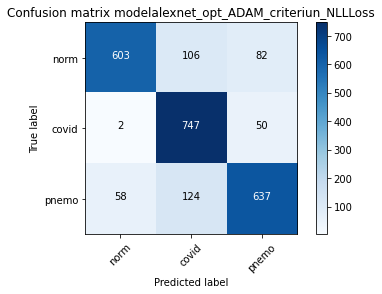

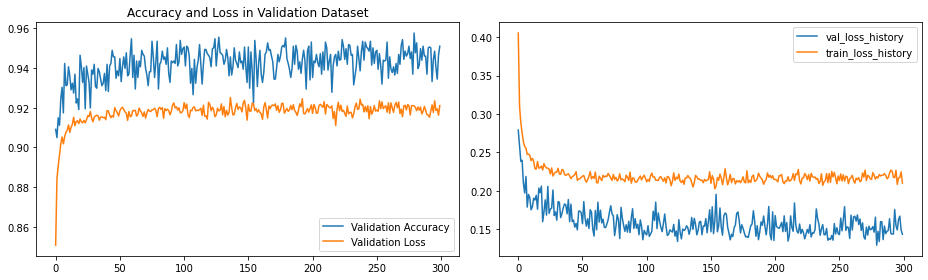


==== END ====
[[775   2  14]
 [  4 776  19]
 [  4  59 756]]

Sensitivity or recall total
0.9576587795765878

Sensitivity or recall per classes
[0.98 0.97 0.92]

Precision
[0.99 0.93 0.96]

F1 Score
[0.98 0.95 0.94]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 2

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -52.4345 Acc: 0.6033
val Loss: -92.2929 Acc: 0.7061

Epoch 1/299
----------
train Loss: -140.5987 Acc: 0.7642
val Loss: -176.1174 Acc: 0.7264

Epoch 2/299
----------
train Loss: -228.0447 Acc: 0.7695
val Loss: -259.6523 Acc: 0.7655

Epoch 3/299
----------
train Loss: -315.0470 Acc: 0.7746
val Loss: -343.5561 Acc: 0.7634

Epoch 4/299
----------
train Loss: -402.7327 Acc: 0.7794
val Loss: -427.3926 Acc: 0.7601

Epoch 5/299
----------
train Loss: -491.0225 Acc

val Loss: -6954.6142 Acc: 0.7883

Epoch 83/299
----------
train Loss: -7318.4456 Acc: 0.7855
val Loss: -7038.1002 Acc: 0.7883

Epoch 84/299
----------
train Loss: -7406.6714 Acc: 0.7872
val Loss: -7122.0294 Acc: 0.7887

Epoch 85/299
----------
train Loss: -7485.4036 Acc: 0.7865
val Loss: -7205.6334 Acc: 0.7883

Epoch 86/299
----------
train Loss: -7585.3557 Acc: 0.7916
val Loss: -7289.3186 Acc: 0.7887

Epoch 87/299
----------
train Loss: -7674.6724 Acc: 0.7850
val Loss: -7372.9289 Acc: 0.7904

Epoch 88/299
----------
train Loss: -7760.0686 Acc: 0.7882
val Loss: -7456.5472 Acc: 0.7904

Epoch 89/299
----------
train Loss: -7849.5531 Acc: 0.7879
val Loss: -7540.1819 Acc: 0.7887

Epoch 90/299
----------
train Loss: -7938.2115 Acc: 0.7881
val Loss: -7623.9095 Acc: 0.7916

Epoch 91/299
----------
train Loss: -8024.3280 Acc: 0.7884
val Loss: -7707.7418 Acc: 0.7916

Epoch 92/299
----------
train Loss: -8100.5100 Acc: 0.7870
val Loss: -7791.4302 Acc: 0.7916

Epoch 93/299
----------
train Loss: 

train Loss: -14820.0099 Acc: 0.7859
val Loss: -14233.0313 Acc: 0.7920

Epoch 170/299
----------
train Loss: -14945.2741 Acc: 0.7879
val Loss: -14316.5649 Acc: 0.7920

Epoch 171/299
----------
train Loss: -15020.9787 Acc: 0.7912
val Loss: -14400.0311 Acc: 0.7920

Epoch 172/299
----------
train Loss: -15145.3593 Acc: 0.7900
val Loss: -14483.7774 Acc: 0.7920

Epoch 173/299
----------
train Loss: -15193.6020 Acc: 0.7880
val Loss: -14567.4302 Acc: 0.7920

Epoch 174/299
----------
train Loss: -15267.5672 Acc: 0.7874
val Loss: -14650.9663 Acc: 0.7924

Epoch 175/299
----------
train Loss: -15392.5424 Acc: 0.7859
val Loss: -14734.9307 Acc: 0.7916

Epoch 176/299
----------
train Loss: -15468.1861 Acc: 0.7899
val Loss: -14818.5741 Acc: 0.7920

Epoch 177/299
----------
train Loss: -15539.3952 Acc: 0.7865
val Loss: -14902.5357 Acc: 0.7920

Epoch 178/299
----------
train Loss: -15626.8506 Acc: 0.7881
val Loss: -14986.1836 Acc: 0.7920

Epoch 179/299
----------
train Loss: -15737.4014 Acc: 0.7879
val 

val Loss: -21345.3473 Acc: 0.7916

Epoch 255/299
----------
train Loss: -22371.0573 Acc: 0.7852
val Loss: -21428.8561 Acc: 0.7916

Epoch 256/299
----------
train Loss: -22457.7549 Acc: 0.7874
val Loss: -21512.2776 Acc: 0.7908

Epoch 257/299
----------
train Loss: -22580.0163 Acc: 0.7889
val Loss: -21595.9067 Acc: 0.7904

Epoch 258/299
----------
train Loss: -22667.9491 Acc: 0.7859
val Loss: -21679.7047 Acc: 0.7904

Epoch 259/299
----------
train Loss: -22711.9734 Acc: 0.7836
val Loss: -21763.5549 Acc: 0.7912

Epoch 260/299
----------
train Loss: -22791.0047 Acc: 0.7865
val Loss: -21847.2556 Acc: 0.7912

Epoch 261/299
----------
train Loss: -22914.8931 Acc: 0.7887
val Loss: -21930.8951 Acc: 0.7912

Epoch 262/299
----------
train Loss: -22979.9151 Acc: 0.7875
val Loss: -22014.6494 Acc: 0.7912

Epoch 263/299
----------
train Loss: -23087.2889 Acc: 0.7898
val Loss: -22098.0653 Acc: 0.7912

Epoch 264/299
----------
train Loss: -23113.5758 Acc: 0.7884
val Loss: -22181.7908 Acc: 0.7904

Epoch

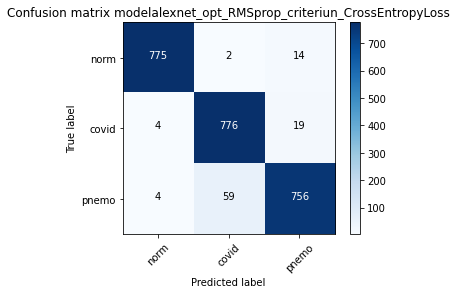

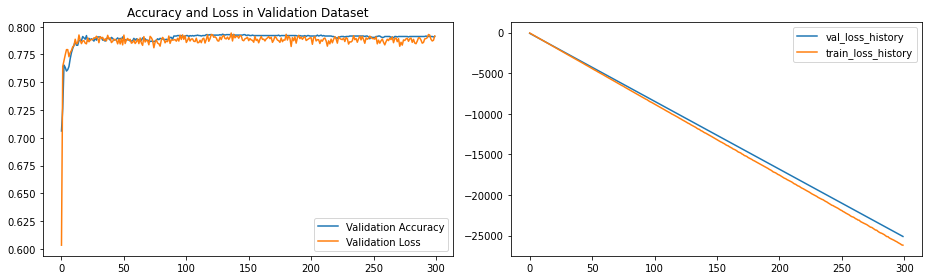


==== END ====
[[625 135  31]
 [  2 773  24]
 [ 68 238 513]]

Sensitivity or recall total
0.7932752179327521

Sensitivity or recall per classes
[0.79 0.97 0.63]

Precision
[0.9  0.67 0.9 ]

F1 Score
[0.84 0.79 0.74]
Confusion matrix, without normalization


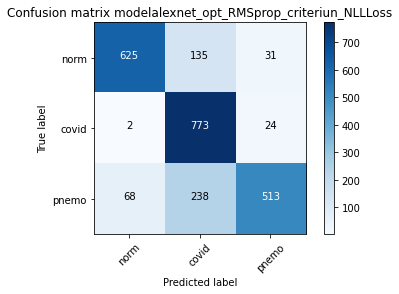

In [11]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 3

_models = ['alexnet'] #['squeezenet', 'densenet', 'resnet', 'alexnet', 'vgg']
lrs = [1e-4]
_epoch = [300]
batch_sizes = [8]
opt = [1, 2, 3]
crt = [1, 2]

for _model in _models:
    for _epochs in _epoch:
        for _lrs in lrs:
            for _batch in batch_sizes:
                for _opt in opt:
                    for _crt in crt:
                               
                        print()
                        print('='*60)
                        print('==== INITIALIZING WITH PARAMETERS: ====')
                        print(f'model -> {_model}')
                        print(f'epochs -> {_epochs}')
                        print(f'lr -> {_lrs}')
                        print(f'batch size -> {_batch}')
                        print(f'optimizer -> {_opt}')
                        print(f'criteriun -> {_crt}')
                        print()

                        feature_extract = True

                        model_ft, input_size = initialize_model(_model, num_classes, 
                                                                feature_extract, use_pretrained=True)

                        # Send the model to GPU
                        model_ft = model_ft.to(device)

                        print('-'*20)
                        params_to_update = model_ft.parameters()
                        print("Params to learn:")
                        if feature_extract:
                            params_to_update = []
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    params_to_update.append(param)
                                    print("\t",name)

                        else:
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    print("\t",name)


                        print()
                        print('-'*20)
                        print()
                        print('== Epochs ==')

                        if _opt == 1:
                            optimizer_ft = optim.SGD(params_to_update, _lrs, momentum=0.9)
                            opt_name = 'SGD'

                        if _opt == 2:
                            optimizer_ft = optim.Adam(params_to_update, _lrs)
                            opt_name = 'ADAM'
                            
                        if _opt == 3:
                            optimizer_ft = optim.RMSprop(params_to_update, _lrs)
                            opt_name = 'RMSprop'


                        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

                        #tray nn.NLLLoss
                        if _crt == 1:
                            criterion = nn.CrossEntropyLoss()
                            crt_name = 'CrossEntropyLoss'
                        if _crt == 2:
                            criterion = nn.NLLLoss()
                            crt_name = 'NLLLoss'

                        model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft,
                                                num_epochs=_epochs, model_name=_model, lr=_lrs,
                                                batch_size=_batch, opt_name=opt_name, crt_name=crt_name)

                        from sklearn.metrics import confusion_matrix

                        nb_classes = 3

                        # Initialize the prediction and label lists(tensors)
                        predlist=torch.zeros(0,dtype=torch.long, device='cpu')
                        lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

                        with torch.no_grad():
                            for i, (inputs, classes) in enumerate(dataloaders['val']):
                                inputs = inputs.to(device) #labels atuais
                                classes = classes.to(device) #classes
                                outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
                                _, preds = torch.max(outputs, 1) #pega o maior valor das predições

                                # Append batch prediction results
                                predlist=torch.cat([predlist,preds.view(-1).cpu()])
                                lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

                        # Confusion matrix
                        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
                        print(conf_mat)
                        print()

                        from sklearn import metrics

                        #analise dos resultados do modelo
                        print('Sensitivity or recall total')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

                        print()
                        print('Sensitivity or recall per classes')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('Precision')
                        print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('F1 Score')
                        print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))

                        cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
                        np.set_printoptions(precision=2)

                        plt.figure()

                        plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], 
                        title='Confusion matrix model'+_model+'_opt_'+opt_name+'_criteriun_'+crt_name)




Os resultados na matriz de confuzão e scores estão ruins, provavelmente pelo param.requires_grad = True 

Testar depois com False

**Peguei o código original**

In [ ]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
########## CAM try 1

In [ ]:
# # hook the feature extractor
# features_blobs = []
# def hook_feature(module, input, output):
#     features_blobs.append(output.data.cpu().numpy())

# model_ft._modules.get(finalconv_name).register_forward_hook(hook_feature)

# # get the softmax weight
# params = list(model_ft.parameters())
# weight_softmax = np.squeeze(params[-2].data.numpy())

# def returnCAM(feature_conv, weight_softmax, class_idx):
#     # generate the class activation maps upsample to 256x256
#     size_upsample = (256, 256)
#     bz, nc, h, w = feature_conv.shape
#     output_cam = []
#     for idx in class_idx:
#         cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
#         cam = cam.reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         cam_img = np.uint8(255 * cam_img)
#         output_cam.append(cv2.resize(cam_img, size_upsample))
#     return output_cam


In [ ]:
# normalize = transforms.Normalize(
#    mean=[0.485, 0.456, 0.406],
#    std=[0.229, 0.224, 0.225]
# )
# preprocess = transforms.Compose([
#    transforms.Resize((224,224)),
#    transforms.ToTensor(),
#    normalize
# ])

# response = requests.get(IMG_URL)
# img_pil = Image.open(io.BytesIO(response.content))
# img_pil.save('test.jpg')

# img_tensor = preprocess(img_pil)
# img_variable = Variable(img_tensor.unsqueeze(0))
# logit = model_ft(img_variable)

# # download the imagenet category list
# # classes = {int(key):value for (key, value)
# #           in requests.get(LABELS_URL).json().items()}

# # h_x = F.softmax(logit, dim=1).data.squeeze()
# # probs, idx = h_x.sort(0, True)
# # probs = probs.numpy()
# # idx = idx.numpy()

# # # output the prediction
# # for i in range(0, 5):
# #     print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# # generate class activation mapping for the top1 prediction
# CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# # render the CAM and output
# # print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
# img = cv2.imread('test.jpg')
# height, width, _ = img.shape
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
# result = heatmap * 0.3 + img * 0.5
# cv2.imwrite('CAM.jpg', result)

In [ ]:
# import IPython.display as display
# from PIL import Image
# image_path = 'CAM.jpg'
# display.display(Image.open(image_path))

In [ ]:
########## CAM try 1 FIIMMMM

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.405])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(1)  # pause a bit so that plots are updated

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, (inputs, classes) in enumerate(dataloaders['test']):
        #inputs, labels = data

        #inputs, labels = Variable(inputs), Variable(labels)
        inputs = inputs.to(device) #labels atuais
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.figure(figsize=(20,20))
            ax = plt.subplot(5, 2, images_so_far)
            ax.axis('off')
            ax.set_title('{}'.format(class_names[predlist[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

#print(dir(model))
visualize_model(model_ft)

In [ ]:
# savePath = "test_model.pth"
# torch.save(model_ft.state_dict(), savePath)

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
#TRY CAM
#do it using RESNET

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd
from torch.autograd import Variable

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
transformers = {
    'train_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'valid_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

trans = ['train_transforms','valid_transforms','test_transforms']

path = "/home/jimi/dissertacao/covid19/datasets/80-20/"
categories = ['train','val','test']
dset = {x : torchvision.datasets.ImageFolder(path+x,
                                             transform=transformers[y]) for x,y in zip(categories, trans)}

dataset_sizes = ['train']


num_threads = 4 
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=16, shuffle=True, num_workers=num_threads)
               for x in categories}

dataset_sizes = {x : len(dset[x]) for x in ['train','val','test']}

class_names = dset['train'].classes

#class_names = image_datasets['train'].classes

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
##### RESNET
##Build model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,3),
            nn.LogSoftmax(dim=1)
        )
        for params in self.model.parameters():
            params.requires_grad = True
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataloaders, num_epochs):
        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(self.model.fc.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        if train_on_gpu:
            self.model = self.model.cuda()
            
        for epoch in range(1, num_epochs+1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)
            
            for phase in ['train','val']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0.0
                
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 600))
        print("best val acc: {:.4f}".format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model
    
model = Model()
model_ft = model.fit(dataloaders,300)

from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


from sklearn import metrics

#analise dos resultados do modelo
print('Sensitivity or recall total')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

print()
print('Sensitivity or recall per classes')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('Precision')
print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('F1 Score')
print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))




epoch 1/300
----------
train loss:  0.2861  acc: 0.8961
val loss:  0.1513  acc: 0.9481
epoch 2/300
----------
train loss:  0.1862  acc: 0.9335
val loss:  0.1124  acc: 0.9606
epoch 3/300
----------
train loss:  0.1733  acc: 0.9355
val loss:  0.1183  acc: 0.9597
epoch 4/300
----------
train loss:  0.1353  acc: 0.9514
val loss:  0.1139  acc: 0.9589
epoch 5/300
----------
train loss:  0.1371  acc: 0.9514
val loss:  0.1076  acc: 0.9618
epoch 6/300
----------
train loss:  0.1363  acc: 0.9499
val loss:  0.1058  acc: 0.9626
epoch 7/300
----------
train loss:  0.1365  acc: 0.9512
val loss:  0.1081  acc: 0.9606
epoch 8/300
----------


In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





In [ ]:
cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
np.set_printoptions(precision=2)

plt.figure()

plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], title='Confusion matrix')

In [ ]:
data_dir_test = "/home/jimi/dissertacao/covid19/datasets/80-20/test/"

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [ ]:
model_ft.eval()

In [ ]:
#print(model)

In [ ]:
#print(model_ft)

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data,sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
# plot predictions
to_pil = transforms.ToPILImage()
images, labels = get_random_images(30)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    
    #print (f'index: {index}')
    #print (f'image: {image}')
    #print (f'labes: {labels}')
    #print (f'classes index :{classes[index]}')
    #print (f'classes 2:{classes}')
    
    sub = fig.add_subplot(8, 4, ii+1)
    
    #print()
    res = int(labels[ii]) == 1
    #print(f'int(labels[ii]): {int(labels[ii])}')
    #print(f'index: {index}')
    #print(f'res = int(labels[ii]) == index: {res}')
    #print()
    
    #print (f'res : {res}')
    
    sub.set_title(str(classes[1]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

In [ ]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/1785.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/860.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/2480.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001.png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-9-a.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-10.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 2 FIIMMMM

In [22]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 3 ref - https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19
########## CAM try 3 ref
########## CAM try 3 ref
########## CAM try 3 ref

In [ ]:
# utils.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from sklearn.manifold import TSNE


def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        cmap = cm.get_cmap("rainbow")
        c = cmap(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.show()
    plt.pause(0.01)

def data_viz(layer, label):
    # https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/401_CNN.ipynb
    tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(layer.data.numpy()[:plot_only, :])
    labels = label.numpy()[:plot_only]
    plot_with_labels(low_dim_embs, labels)


def plot_test_image_result(img, ps, le, cam=None):

    _ = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])

    if cam is not None:
        ax1.imshow(cam, alpha=0.6)
        ax1.imshow(img, alpha=0.4)
    else:
        ax1.imshow(img)

    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))

    for i, v in enumerate(ps):
        ax2.text(
            .01,
            i-0.1,
            f'{v:.3f}',
            color='blue',
            fontweight='bold')

    if le is None:
        ax2.set_yticklabels(np.arange(len(ps)))
    else:
        ax2.set_yticklabels(le.inverse_transform(np.arange(len(ps))))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

In [ ]:
# makedataset.py

from os.path import isfile, join
from os import walk
import pandas as pd
import numpy as np
from itertools import tee

from sklearn.model_selection import train_test_split

if __name__ == "__main__":

    path = "./data"
    sample_per_category = 500
    seed = 24
    split_frac = 0.20

    df_raw = None

    genFiles = (
        (dirpath, dirnames, filenames) for (dirpath, dirnames, filenames) in walk(path)
    )

    files, genFiles = tee(genFiles)
    file_count = sum(len(f) for _, _, f in files)

    df_raw = pd.DataFrame(
        data=np.nan, index=np.arange(0, file_count - 1), columns=["LABEL", "FILE"]
    )

    files, genFiles = tee(genFiles)
    idx = 0
    for r, _, f in files:
        for _f in f:
            if isfile(join(r, _f)) and _f.endswith(
                (".jpeg", ".png", "jpg", ".JPEG", ".PNG", "JPG")
            ):
                path = "/".join((r, _f))
                *_, label = r.split("/")
                df_raw.iloc[idx] = [label, path]
                idx += 1

    df_raw.to_csv("./data/raw.csv", index=False)

    # # 3-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 3),
        columns=["FILE", "LABEL"],
    )

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/3_class_train_df.csv", index=False)
    test_df.to_csv("./data/3_class_test_df.csv", index=False)

    print(f"\n3_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"3_class_test_df:\n{test_df['LABEL'].value_counts()}")

    # 2-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 2),
        columns=["FILE", "LABEL"],
    )

    index = df_raw[df_raw["LABEL"] == "pneumonia"].index
    df_raw.drop(index, inplace=True)

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/2_class_train_df.csv", index=False)
    test_df.to_csv("./data/2_class_test_df.csv", index=False)

    print(f"\n2_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"2_class_test_df:\n{test_df['LABEL'].value_counts()}")

In [ ]:
# architectures.py

import torch.nn as nn
from torchvision.models import resnet50


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class Rn50(nn.Module):
    def __init__(self, device, train_base=False, classes=2):
        super(Rn50, self).__init__()

        self.device = device

        self.net_back = resnet50(pretrained=True).to(self.device)
        self._trainable(train_base)

        fc_size = self.net_back.fc.in_features
        self.net_back.fc = Identity()

        self.net_head = nn.Sequential(
            nn.Linear(in_features=fc_size, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=classes),
            nn.LogSoftmax(dim=1),
        ).to(self.device)

    def forward(self, x):
        x = self.net_back(x.to(self.device))
        x = x.view(x.size(0), -1)
        return self.net_head(x.to(self.device))

    def _trainable(self, flag):
        for param in self.net_back.parameters():
            param.requires_grad = flag


# old way
# modules = list(resnet50(pretrained=True).children())[:-1]
# self.net_back = nn.Sequential(*modules).to(self.device)
# fc_size = list(self.net_back.parameters())[-1].size(0)
# self.net_head = nn.Sequential(...).to(self.device)

In [ ]:
# activationmap.py

import torch


class FeatureBuffer():

    features=None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # self.features = ((output.cpu()).data).numpy()
        self.features = output

    def remove(self):
        self.hook.remove()


# def GradCam(model, input_image_tensor):

#     https://github.com/tyui592/class_activation_map/blob/master/cam.py
#     https://github.com/daixiangzi/Grad_Cam-pytorch-resnet50/blob/578db29d13b0e7d17aa53d9bac116674771618ec/test_grad_cam.py#L19
#     https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html
#     https://github.com/MarcoCBA/Class-Activation-Maps-PyTorch/blob/master/class_activation_maps.ipynb

#     print(model)

#     final_conv_layer = model.net_back._modules.get('layer4')
#     fc_layer = model.net_head._modules.get('0')
#     fb = FeatureBuffer(final_conv_layer)

#     model = model.eval()
#     out = model(input_image_tensor)

#      # based on model caluculate output!!!
#     probabilities = torch.exp(out)
#     _, predicted = torch.max(probabilities, 1)
#     feature_maps = fb.features

#     print("Output's shape: ", out.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     weights_and_biases = list(fc_layer.parameters())
#     class_weights = weights_and_biases[0][predicted]
#     print("Weights's shape: ", weights_and_biases[0].shape)
#     print("Biases's shape: ", weights_and_biases[1].shape)
#     print("Class weights's shape :", class_weights.shape)

#     class_weights = class_weights.reshape((-1, 1, 1))
#     feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
#     print("Class weights's shape :", class_weights.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach(), dtype=np.float32)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(class_activation_maps)
#     plt.show()

#     resized_cam = cv2.resize(class_activation_maps, dsize=(224, 224), interpolation=cv2.INTER_LANCZOS4)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(resized_cam)
#     plt.show()

In [ ]:
# train.py

import math
from time import time
from copy import deepcopy

import torch

try:
    from torchsummary import summary
except:
    MODELSUMMARY = False
else:
    MODELSUMMARY = True

try:
    from sklearn.manifold import TSNE
except:
    VIZTSNE = False
else:
    VIZTSNE = True


def train_model(
    model,
    device,
    criterion,
    optimizer,
    dataloaders,
    dataloader_len,
    input_shape,
    scheduler=None,
    num_epochs=50,
):

    if MODELSUMMARY:
        summary(model, input_data=input_shape)

    start = time()
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        t_epoch = time()
        print(f"epoch: {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for idx, (labels, inputs) in enumerate(dataloaders[phase]):
                iter_batch = math.ceil(
                    dataloader_len[phase] / dataloaders[phase].batch_size
                )
                print(f"[phase: {phase}] batch: {idx+1}/{iter_batch}", end="\r")

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                if scheduler is not None:
                    scheduler.step()

            epoch_loss = running_loss / dataloader_len[phase]
            epoch_acc = running_corrects.double() / dataloader_len[phase]
            print(f"[phase: {phase}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                print(f"[saving model] epoch: {epoch+1} Acc: {epoch_acc:.4f}")
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        t_elapsed = time() - t_epoch
        print(f"epoch training complete in {t_elapsed//60:.0f}m {t_elapsed%60:.0f}s")
        print()

    time_elapsed = time() - start
    print(f"training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)

    checkpoint = {
        "input_shape": input_shape,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

    torch.save(checkpoint, "./models/checkpoint.pth")
    return model

In [ ]:
# test.py

import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scripts.activationmap import FeatureBuffer
from sklearn.metrics import classification_report, confusion_matrix

#from .utils import plot_test_image_result


def test_model(model, testloader, device, encoder=None):

    correct = 0
    total = 0
    true_list = list()
    pred_list = list()

    for idx, (labels, inputs) in enumerate(testloader):
        iter_batch = math.ceil(len(testloader.dataset)/testloader.batch_size)
        print(f'[phase: test] batch: {idx+1}/{iter_batch}', end='\r')

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            probabilities = torch.exp(outputs)
            _, predicted = torch.max(probabilities, 1)

            total = idx + 1
            correct += torch.sum(predicted == labels.data)
            true_list.append((labels.data.cpu()).numpy().item())
            pred_list.append((predicted.cpu()).numpy().item())

    acc = 100*(correct.item()/total)
    print(f"[phase: test] total: {total}, correct: {correct}, acc: {acc:.3f}")

    print(classification_report(tuple(true_list), tuple(pred_list)))

    y_true = pd.Series(true_list, name='Actual')
    y_pred = pd.Series(pred_list, name='Predicted')
    cm = pd.crosstab(y_true, y_pred,  margins=True)

    print("confusion matrix")
    if encoder is not None:
        print({i : encoder.classes_[i] for i in range(0, len(encoder.classes_))})
    print(cm)



def test_image(model, image, in_shape, transform, device, labelencoder=None, cam=None):
    """
    GradCam
    """

    if cam is not None:
        final_conv_layer = model.net_back._modules.get('layer4')
        fc_layer = model.net_head._modules.get('0')
        fb = FeatureBuffer(final_conv_layer)

    input_tensor = transform(image).unsqueeze(0)
    inputs = input_tensor.to(device)

    model = model.eval()
    outputs = model(inputs)
    probabilities = torch.exp(outputs)
    prob = (probabilities.cpu()).detach().numpy().flatten()

    if cam is not None:
        _, predicted = torch.max(probabilities, 1)
        feature_maps = fb.features

        weights_and_biases = list(fc_layer.parameters())
        class_weights = weights_and_biases[0][predicted]

        class_weights = class_weights.reshape((-1, 1, 1))
        feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)

        class_activation_maps = np.array(
            torch.sum(feature_maps * class_weights, dim=0).cpu().detach(),
            dtype=np.float32)

        cam_map = cv2.resize(
            class_activation_maps,
            dsize=in_shape,
            interpolation=cv2.INTER_LANCZOS4)

    if cam is not None:
        plot_test_image_result(image.resize(in_shape), prob, labelencoder, cam_map)
    else:
        plot_test_image_result(image, prob, labelencoder)

In [ ]:
# evaluate.py 

import torch
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from PIL import Image

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.test import test_model, test_image


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"

test_file = "data/3_class_test_df.csv"
image_file = "data/raw/covid/covid_001.jpg"
num_workers = 2
batch_size = 1
input_shape = (256, 256)
le = LabelEncoder()

df = pd.read_csv(test_file)

test_transforms = transforms.Compose(
    [
        transforms.Resize(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_set = Datagen(df, l_encoder=le, transforms=test_transforms)
label_enc = test_set.get_le()
device = get_device()

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers,
)

model = Rn50(device=device, classes=3)
model.load_state_dict(torch.load("./models/checkpoint.pth")["state_dict"])

test_model(
    model=model,
    testloader=test_loader,
    device=device,
    encoder=label_enc)

input_image = Image.open(image_file).convert("RGB")
test_image(
    model=model,
    image=input_image,
    in_shape=input_shape,
    transform=test_transforms,
    device=device,
    labelencoder=label_enc,
    cam=True
)

In [ ]:
# datagen.py

from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image


class Datagen(Dataset):
    def __init__(self, dataframe, transforms=None, l_encoder=None):
        self.df = dataframe
        self.transforms = transforms
        self.encoder = l_encoder

        if self.encoder is not None:
            self.df["LABEL"] = self.encoder.fit_transform(self.df["LABEL"])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        label = self.df.iloc[idx, 0]
        image_file = self.df.iloc[idx, 1]
        image = Image.open(image_file).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        # print(image.shape)
        return (label, image)

    def get_le(self):
        return self.encoder

In [ ]:
# trainer.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.train import train_model


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"


train_file = "data/3_class_train_df.csv"
num_workers = 2
val_split = 0.2
batch_size = 32
num_epochs = 20
input_shape = (3, 256, 256)
le = LabelEncoder()

df = pd.read_csv(train_file)

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_set = Datagen(df, l_encoder=le, transforms=train_transforms)
validation_set = Datagen(df, l_encoder=le, transforms=validation_transforms)

train_idx, val_idx = train_test_split(list(range(len(df))), test_size=val_split)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(
    train_set,
    # shuffle=True,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
)

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    # shuffle=False,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
)

device = get_device()
net = Rn50(device=device, classes=3)

dataloaders = {"train": train_loader, "val": valid_loader}
dataloader_len = {"train": len(train_idx), "val": len(val_idx)}

criteration = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(
    model=net,
    device=device,
    criterion=criteration,
    optimizer=optimizer,
    dataloaders=dataloaders,
    dataloader_len=dataloader_len,
    input_shape=input_shape,
    num_epochs=num_epochs,
)

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM

In [ ]:
########## CAM functional

In [ ]:
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://diariodonordeste.verdesmares.com.br/image/contentid/policy:1.2966908:1594933666/ferramenta-sesa.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

#net.eval()

In [ ]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable) ## aqui tem algo

# # download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# # output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

In [ ]:
import IPython.display as display
from PIL import Image
image_path = 'CAM.jpg'
display.display(Image.open(image_path))

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")